### Name generation character by character pytorch tutorial

In an effort to understand pytorch and rnns better

Reference: https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

In [27]:
import glob
import os
import matplotlib.pyplot as plt
import unicodedata
import string
import time
import math
import torch
import torch.nn as nn

In [4]:
# path to names dataset
DATASET_ROOT = '/Users/rohit/Desktop/datasets'
DATASET_PATH = os.path.join(DATASET_ROOT, 'names/names')

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

In [5]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

category_lines = {}
all_categories = []

for filename in glob.glob(os.path.join(DATASET_PATH, "*.txt")):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

num_categories = len(all_categories)
print(f"Num categories: {num_categories}")


Num categories: 18


In [25]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size) -> None:
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(num_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(num_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [8]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    name = randomChoice(category_lines[category])
    return category, name

('Czech', 'Dopita')


In [13]:
print(randomTrainingPair())

('Japanese', 'Kunomasu')


In [14]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, num_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [17]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [21]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [23]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [26]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 4s (5000 5%) 2.9985
0m 8s (10000 10%) 2.9823
0m 11s (15000 15%) 2.9782
0m 16s (20000 20%) 2.3755
0m 19s (25000 25%) 2.9389
0m 23s (30000 30%) 1.9329
0m 27s (35000 35%) 2.0430
0m 31s (40000 40%) 2.7571
0m 35s (45000 45%) 2.1085
0m 39s (50000 50%) 2.5581
0m 43s (55000 55%) 3.2305
0m 47s (60000 60%) 2.6767
0m 51s (65000 65%) 2.2452
0m 55s (70000 70%) 2.3630
1m 0s (75000 75%) 2.2797
1m 4s (80000 80%) 3.4750
1m 8s (85000 85%) 2.6468
1m 12s (90000 90%) 1.6755
1m 16s (95000 95%) 2.0304
1m 20s (100000 100%) 2.4416


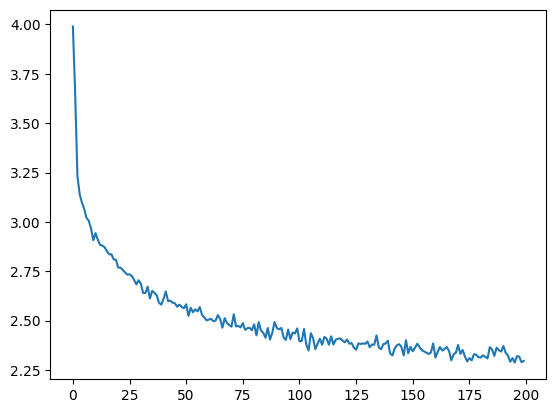

In [28]:
plt.figure()
plt.plot(all_losses)

In [29]:
max_length = 20

def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

In [31]:
print(sample('Russian', 'P'))

print(sample('Russian', 'V'))

print(sample('Chinese', 'V'))

Pantonov
Vander
